In [ ]:
import numpy as np
import pandas as pd

In [ ]:
train_data = pd.read_csv("train.csv", index_col="tripid")
test_features_df = pd.read_csv("test.csv", index_col="tripid")

In [ ]:
train_data=train_data.dropna(how='any',axis=0)

In [ ]:
# check label counts
train_data.label.value_counts()

correct      15442
incorrect     1526
Name: label, dtype: int64

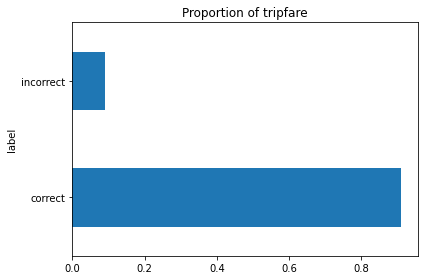

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, sharex=True)

n_obs = train_data.label.shape[0]

(train_data['label']
    .value_counts()
    .div(n_obs)
    .plot.barh(title="Proportion of tripfare")
)
ax.set_ylabel("label")
fig.tight_layout()

In [ ]:
# # separate minority and majority classes
# incorrect = train_data[train_data.label=="incorrect"]
# correct = train_data[train_data.label=="correct"]

# from sklearn.utils import resample
# # upsample minority
# incorrect_upsampled = resample(incorrect,
#                           replace=True, # sample with replacement
#                           n_samples=len(correct), # match number in majority class
#                           random_state=27) # reproducible results

# # combine majority and upsampled minority
# upsampled_train_data = pd.concat([correct, incorrect_upsampled])

# # check new class counts
# upsampled_train_data.label.value_counts()

In [ ]:
features_df = train_data.iloc[:, :12]
labels_df = train_data.iloc[:, 12:]
# features_df = upsampled_train_data.iloc[:, :12]
# labels_df = upsampled_train_data.iloc[:, 12:]
# Separate input features and target
# labels_df = train_data.label
# features_df = train_data.drop('label', axis=1)

In [ ]:
np.testing.assert_array_equal(features_df.index.values, labels_df.index.values)

In [ ]:
features_df.shape, labels_df.shape

((16968, 12), (16968, 1))

In [ ]:
features_df['pickup_time'] = features_df['pickup_time'].astype('datetime64')
test_features_df['pickup_time'] = test_features_df['pickup_time'].astype('datetime64')
features_df['drop_time'] = features_df['drop_time'].astype('datetime64')
test_features_df['drop_time'] = test_features_df['drop_time'].astype('datetime64')

In [ ]:
import datetime
features_df['pick_up_day'] = features_df['pickup_time'].dt.dayofweek
features_df['drop_day'] = features_df['drop_time'].dt.dayofweek
test_features_df['pick_up_day'] = test_features_df['pickup_time'].dt.dayofweek
test_features_df['drop_day'] = test_features_df['drop_time'].dt.dayofweek


In [ ]:
import datetime
features_df['pick_up_hour'] = features_df['pickup_time'].dt.hour
test_features_df['pick_up_hour'] = test_features_df['pickup_time'].dt.hour

In [ ]:
features_df.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,pick_up_day,drop_day,pick_up_hour
tripid,,,,,,,,,,,,,,,
189123628,10.5,834.0,56.0,0.0000,64.0,2019-11-01 00:20:00,2019-11-01 00:34:00,6.86252,79.8993,6.90330,79.8783,270.32,4,4,0
189125358,10.5,791.0,47.0,0.0000,134.0,2019-11-01 00:56:00,2019-11-01 01:09:00,6.88589,79.8984,6.91373,79.8923,197.85,4,4,0
189125719,10.5,1087.0,80.0,0.0000,61.0,2019-11-01 01:08:00,2019-11-01 01:26:00,6.90839,79.8651,6.93669,79.9146,301.64,4,4,1
189127273,10.5,598.0,271.0,15.6638,68.0,2019-11-01 02:27:00,2019-11-01 02:37:00,6.92570,79.8895,6.92748,79.8971,82.30,4,4,2
189129552,10.5,3407.0,182.0,0.0000,112.0,2019-11-01 05:38:00,2019-11-01 06:35:00,7.13402,79.8969,6.91865,79.8649,1065.02,4,4,5


In [ ]:
def distance(df):
  from math import sin, cos, sqrt, atan2, radians
  for index, row in df.iterrows():
    
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(row['pick_lat'])
    lon1 = radians(row['pick_lon'])
    lat2 = radians(row['drop_lat'])
    lon2 = radians(row['drop_lon'])
  
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    
    df.loc[index, 'distance'] = distance

features_df['distance']=''
test_features_df['distance']=''

distance(features_df)
distance(test_features_df)

features_df['distance'] = features_df['distance'].astype(float)
test_features_df['distance'] = test_features_df['distance'].astype(float)
features_df.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,pick_up_day,drop_day,pick_up_hour,distance
tripid,,,,,,,,,,,,,,,,
189123628,10.5,834.0,56.0,0.0000,64.0,2019-11-01 00:20:00,2019-11-01 00:34:00,6.86252,79.8993,6.90330,79.8783,270.32,4,4,0,5.094369
189125358,10.5,791.0,47.0,0.0000,134.0,2019-11-01 00:56:00,2019-11-01 01:09:00,6.88589,79.8984,6.91373,79.8923,197.85,4,4,0,3.169052
189125719,10.5,1087.0,80.0,0.0000,61.0,2019-11-01 01:08:00,2019-11-01 01:26:00,6.90839,79.8651,6.93669,79.9146,301.64,4,4,1,6.307375
189127273,10.5,598.0,271.0,15.6638,68.0,2019-11-01 02:27:00,2019-11-01 02:37:00,6.92570,79.8895,6.92748,79.8971,82.30,4,4,2,0.862217
189129552,10.5,3407.0,182.0,0.0000,112.0,2019-11-01 05:38:00,2019-11-01 06:35:00,7.13402,79.8969,6.91865,79.8649,1065.02,4,4,5,24.214638


In [ ]:
def travelling_time(df):
  for index, row in df.iterrows():
    travel_time = row['duration'] - row['meter_waiting']
    df.loc[index, 'travel_time'] = travel_time

features_df['travel_time']=''
test_features_df['travel_time']=''

travelling_time(features_df)
travelling_time(test_features_df)

features_df['travel_time'] = features_df['travel_time'].astype(int)
test_features_df['travel_time'] = test_features_df['travel_time'].astype(int)
features_df.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,pick_up_day,drop_day,pick_up_hour,distance,travel_time
tripid,,,,,,,,,,,,,,,,,
189123628,10.5,834.0,56.0,0.0000,64.0,2019-11-01 00:20:00,2019-11-01 00:34:00,6.86252,79.8993,6.90330,79.8783,270.32,4,4,0,5.094369,778
189125358,10.5,791.0,47.0,0.0000,134.0,2019-11-01 00:56:00,2019-11-01 01:09:00,6.88589,79.8984,6.91373,79.8923,197.85,4,4,0,3.169052,744
189125719,10.5,1087.0,80.0,0.0000,61.0,2019-11-01 01:08:00,2019-11-01 01:26:00,6.90839,79.8651,6.93669,79.9146,301.64,4,4,1,6.307375,1007
189127273,10.5,598.0,271.0,15.6638,68.0,2019-11-01 02:27:00,2019-11-01 02:37:00,6.92570,79.8895,6.92748,79.8971,82.30,4,4,2,0.862217,327
189129552,10.5,3407.0,182.0,0.0000,112.0,2019-11-01 05:38:00,2019-11-01 06:35:00,7.13402,79.8969,6.91865,79.8649,1065.02,4,4,5,24.214638,3225


In [ ]:
def travel_fare(df):
  for index, row in df.iterrows():
    travel_fare = row['fare'] - row['additional_fare'] - row['meter_waiting_fare'] 
    df.loc[index, 'travel_fare'] = travel_fare

features_df['travel_fare']=''
test_features_df['travel_fare']=''

travel_fare(features_df)
travel_fare(test_features_df)

features_df['travel_fare'] = round(features_df['travel_fare'].astype(float), 2)
test_features_df['travel_fare'] = round(test_features_df['travel_fare'].astype(float), 2)
features_df.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,pick_up_day,drop_day,pick_up_hour,distance,travel_time,travel_fare
tripid,,,,,,,,,,,,,,,,,,
189123628,10.5,834.0,56.0,0.0000,64.0,2019-11-01 00:20:00,2019-11-01 00:34:00,6.86252,79.8993,6.90330,79.8783,270.32,4,4,0,5.094369,778,259.82
189125358,10.5,791.0,47.0,0.0000,134.0,2019-11-01 00:56:00,2019-11-01 01:09:00,6.88589,79.8984,6.91373,79.8923,197.85,4,4,0,3.169052,744,187.35
189125719,10.5,1087.0,80.0,0.0000,61.0,2019-11-01 01:08:00,2019-11-01 01:26:00,6.90839,79.8651,6.93669,79.9146,301.64,4,4,1,6.307375,1007,291.14
189127273,10.5,598.0,271.0,15.6638,68.0,2019-11-01 02:27:00,2019-11-01 02:37:00,6.92570,79.8895,6.92748,79.8971,82.30,4,4,2,0.862217,327,56.14
189129552,10.5,3407.0,182.0,0.0000,112.0,2019-11-01 05:38:00,2019-11-01 06:35:00,7.13402,79.8969,6.91865,79.8649,1065.02,4,4,5,24.214638,3225,1054.52


In [ ]:
features_df=features_df.drop(['pickup_time'], axis=1)
features_df=features_df.drop(['drop_time'], axis=1)
test_features_df=test_features_df.drop(['pickup_time'], axis=1)
test_features_df=test_features_df.drop(['drop_time'], axis=1)

In [ ]:
col = ['additional_fare', 'duration', 'meter_waiting', 'meter_waiting_fare', 'meter_waiting_till_pickup', 'pick_lat',
'pick_lon', 'drop_lat', 'drop_lon', 'fare', 'pick_up_day', 'distance', 'travel_time', 'pick_up_hour', 'drop_day', 'travel_fare'] 

features_df=features_df[col] 
test_features_df=test_features_df[col]


In [ ]:
features_df.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,pick_up_day,distance,travel_time,pick_up_hour,drop_day,travel_fare
tripid,,,,,,,,,,,,,,,,
189123628,10.5,834.0,56.0,0.0000,64.0,6.86252,79.8993,6.90330,79.8783,270.32,4,5.094369,778,0,4,259.82
189125358,10.5,791.0,47.0,0.0000,134.0,6.88589,79.8984,6.91373,79.8923,197.85,4,3.169052,744,0,4,187.35
189125719,10.5,1087.0,80.0,0.0000,61.0,6.90839,79.8651,6.93669,79.9146,301.64,4,6.307375,1007,1,4,291.14
189127273,10.5,598.0,271.0,15.6638,68.0,6.92570,79.8895,6.92748,79.8971,82.30,4,0.862217,327,2,4,56.14
189129552,10.5,3407.0,182.0,0.0000,112.0,7.13402,79.8969,6.91865,79.8649,1065.02,4,24.214638,3225,5,4,1054.52


In [ ]:
test_features_df.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,pick_up_day,distance,travel_time,pick_up_hour,drop_day,travel_fare
tripid,,,,,,,,,,,,,,,,
213284604,10.5,924,42,2.4486,148,6.83454,79.8750,6.77490,79.8840,289.27,5,6.707807,882,0,5,276.32
213286352,10.5,4249,20,0.0000,91,6.91168,79.8723,6.55091,79.9706,1912.70,5,41.571559,4229,1,5,1902.20
213293973,10.5,1552,255,2.6588,23,6.92145,79.8478,6.90539,79.8989,394.00,5,5.918535,1297,5,5,380.84
213294622,10.5,462,16,0.0000,198,6.77433,79.9416,6.80401,79.9407,154.32,5,3.302798,446,5,5,143.82
213298687,10.5,814,392,12.3692,69,6.97968,79.9130,6.98875,79.8914,147.47,5,2.589354,422,7,5,124.60


In [ ]:
labels_df.head()

,label
tripid,
189123628,correct
189125358,correct
189125719,correct
189127273,correct
189129552,correct


In [ ]:
# #Label Encoding for object to numeric conversion
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()

# labels_df["label"] = le.fit_transform(labels_df["label"].astype(str))
def tran_label_to_num(df):
    if df['label'] == 'correct':
        return 1
    elif df['label'] == 'incorrect':
        return 0
# create sex_new 
labels_df['label']=labels_df.apply(tran_label_to_num,axis=1)
labels_df.head()

,label
tripid,
189123628,1
189125358,1
189125719,1
189127273,1
189129552,1


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve, roc_auc_score

RANDOM_SEED = 6    # Set a random seed for reproducibility!

In [ ]:
numeric_cols = features_df.columns[features_df.dtypes != "object"].values
print(numeric_cols)
print(numeric_cols.size)

['additional_fare' 'duration' 'meter_waiting' 'meter_waiting_fare'
 'meter_waiting_till_pickup' 'pick_lat' 'pick_lon' 'drop_lat' 'drop_lon'
 'fare' 'pick_up_day' 'distance' 'travel_time' 'pick_up_hour' 'drop_day'
 'travel_fare']
16


In [ ]:
# chain preprocessing into a Pipeline object
# each step is a tuple of (name you chose, sklearn transformer)
numeric_preprocessing_steps = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('simple_imputer', SimpleImputer(strategy='median'))
])

# create the preprocessor stage of final pipeline
# each entry in the transformer list is a tuple of
# (name you choose, sklearn transformer, list of columns)
preprocessor = ColumnTransformer(
    transformers = [
        ("numeric", numeric_preprocessing_steps, numeric_cols)
    ],
    remainder = "drop"
)

In [ ]:
from xgboost import XGBClassifier
estimators = MultiOutputClassifier(
    estimator=XGBClassifier(learning_rate =0.01,
 n_estimators=3000,
 max_depth=4,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0.005,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
)

In [ ]:
X_train, X_eval, y_train, y_eval = train_test_split(
    features_df,
    labels_df,
    test_size=0.33,
    shuffle=True,
    stratify=labels_df,
    random_state=RANDOM_SEED
)

In [ ]:
X_train.shape,y_train.shape

((11368, 16), (11368, 1))

In [ ]:
%%time
full_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("estimators", estimators),
])
# Train model
full_pipeline.fit(X_train, y_train)

CPU times: user 54.7 s, sys: 1.48 s, total: 56.2 s
Wall time: 30.9 s


In [ ]:
y_pred = full_pipeline.predict(X_eval)
y_pred

array([[0],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [ ]:
 from sklearn.metrics import accuracy_score
 accuracy_score(y_eval, y_pred)
 # 0.95375 n_estimators=5000
 # 0.9539285714285715 n_estimators=5000
 # 0.9548214285714286 n_estimators=3000

0.9548214285714286

In [ ]:
 from sklearn.metrics import f1_score
f1_score(y_eval, y_pred, average='macro')
# 0.8349567404365886
# 0.8364775489378964
# 0.8387801364110306

0.8387801364110306

In [ ]:
%%time
full_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("estimators", estimators),
])
# Train model
full_pipeline.fit(features_df, labels_df)

CPU times: user 1min 19s, sys: 1.61 s, total: 1min 21s
Wall time: 44.5 s


In [ ]:
test_probas = full_pipeline.predict(test_features_df)
test_probas

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [ ]:
submission_df = pd.read_csv("sample_submission.csv", 
                            index_col="tripid")

In [ ]:
# Make sure we have the rows in the same order
np.testing.assert_array_equal(test_features_df.index.values, 
                              submission_df.index.values)

# Save predictions to submission data frame
submission_df["prediction"] = test_probas[:, 0]


submission_df

,prediction
tripid,
213284604,1
213286352,1
213293973,1
213294622,1
213298687,1
...,...
222856243,1
222857785,1
222858416,1


In [ ]:
submission_df.to_csv('ML_submission.csv', index=True)

In [ ]:
!head ML_submission.csv

tripid,prediction
213284604,1
213286352,1
213293973,1
213294622,1
213298687,1
213299545,1
213302332,1
213302671,1
213305594,1
